{'0': 'Ace', '1': 'Akainu', '2': 'Brook', '3': 'Chopper', '4': 'Crocodile', '5': 'Franky', '6': 'Jinbei', '7': 'Kurohige', '8': 'Law', '9': 'Luffy', '10': 'Mihawk', '11': 'Nami', '12': 'Rayleigh', '13': 'Robin', '14': 'Sanji', '15': 'Shanks', '16': 'Usopp', '17': 'Zoro'}


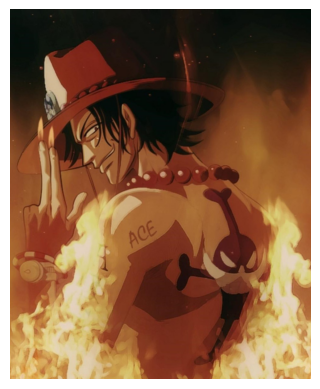

In [3]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score
from tqdm import tqdm
import torch
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torch.optim.lr_scheduler import CosineAnnealingLR
import time
import pandas as pd
import matplotlib.pyplot as plt
from torch.profiler import profile, record_function, ProfilerActivity


train_dir = 'train'
test_dir = 'test'
labels_path = 'labels.json'
with open(labels_path, 'r') as f:
    labels = json.load(f)
print(labels)
sample_image_path = os.path.join(train_dir, 'Ace/2.jpg')
image = Image.open(sample_image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [5]:
with open(labels_path, 'r') as f:
    labels = json.load(f)

In [7]:
class OnePieceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir)) 
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        for cls_name in self.classes:
            cls_dir = os.path.join(root_dir, cls_name)
            if os.path.isdir(cls_dir):
                for img_name in os.listdir(cls_dir):
                    img_path = os.path.join(cls_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[cls_name])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dir = 'train'
train_dataset = OnePieceDataset(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [9]:
train_dir = 'train'
train_dataset = OnePieceDataset(train_dir)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_dataset.image_paths, train_dataset.labels, test_size=0.2, random_state=42, stratify=train_dataset.labels
)

class OnePieceAugmentedDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [11]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
train_data = OnePieceAugmentedDataset(train_paths, train_labels, transform=train_transform)
val_data = OnePieceAugmentedDataset(val_paths, val_labels, transform=val_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [15]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_classes = 18
model.fc = nn.Linear(model.fc.in_features, num_classes)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

results = {"epoch": [], "train_loss": [], "val_loss": [], "val_accuracy": [], "epoch_time": []}
experiment_logs = []
num_epochs = 10
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()
    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA] if torch.cuda.is_available() else [ProfilerActivity.CPU],
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./logs'),
        record_shapes=True,
        with_stack=True
    ) as prof:
        for batch_idx, (images, labels) in enumerate(train_loader, start=1):
            with record_function("training_step"):
                for images, labels in train_loader:
                    labels = labels - 1  # Уменьшаем метки на 1
                    images, labels = images.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
            if batch_idx % 10 == 0:
                    print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")
    scheduler.step()
    train_loss = running_loss / len(train_loader)
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            labels = labels - 1
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    epoch_time = time.time() - start_time
    results["epoch"].append(epoch + 1)
    results["train_loss"].append(train_loss)
    results["val_loss"].append(val_loss)
    results["val_accuracy"].append(val_accuracy)
    results["epoch_time"].append(epoch_time)

    experiment_logs.append({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "lr": scheduler.get_last_lr()
    })

    print(f"Epoch {epoch + 1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}, Time: {epoch_time:.2f}s")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_resnet50.pth")
        print(f"Model saved with accuracy: {val_accuracy:.4f}")

df_results = pd.DataFrame(results)
df_results.to_csv("training_results.csv", index=False)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(results["epoch"], results["train_loss"], label="Train Loss")
plt.plot(results["epoch"], results["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss during Training")

plt.subplot(1, 2, 2)
plt.plot(results["epoch"], results["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.savefig("training_plots.png")
plt.show()

print("\n experiments")
for log in experiment_logs:
    print(log)
best_model_path = 'best_resnet50.pth'
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

STAGE:2024-11-22 19:37:22 75376:4773977 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


In [17]:
# ноутбук не потянул профайлинг, так что без него

In [ ]:
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

results = {"epoch": [], "train_loss": [], "val_loss": [], "val_accuracy": [], "epoch_time": []}
experiment_logs = []
num_epochs = 10
best_val_accuracy = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()
    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        labels = labels - 1  
        images, labels = images.to(device), labels.to(device)    
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)    
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")

    scheduler.step()
    train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            labels = labels - 1
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = correct / total
    epoch_time = time.time() - start_time
    results["epoch"].append(epoch + 1)
    results["train_loss"].append(train_loss)
    results["val_loss"].append(val_loss)
    results["val_accuracy"].append(val_accuracy)
    results["epoch_time"].append(epoch_time)

    experiment_logs.append({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "lr": scheduler.get_last_lr()
    })

    print(f"Epoch {epoch + 1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}, Time: {epoch_time:.2f}s")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_resnet50.pth")
        print(f"Model saved with accuracy: {val_accuracy:.4f}")

df_results = pd.DataFrame(results)
df_results.to_csv("training_results.csv", index=False)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(results["epoch"], results["train_loss"], label="Train Loss")
plt.plot(results["epoch"], results["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss during Training")

plt.subplot(1, 2, 2)
plt.plot(results["epoch"], results["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")

plt.savefig("training_plots.png")
plt.show()

print("\Experiments")
for log in experiment_logs:
    print(log)

best_model_path = 'best_resnet50.pth'
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

<>:96: SyntaxWarning: invalid escape sequence '\E'
<>:96: SyntaxWarning: invalid escape sequence '\E'
/var/folders/pw/r0x6r4rd0fg_394tyggz0gkm0000gn/T/ipykernel_94793/6500219.py:96: SyntaxWarning: invalid escape sequence '\E'
  print("\Experiments")
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Batch [10/73], Loss: 3.1982
Epoch [1/10], Batch [20/73], Loss: 2.6131
Epoch [1/10], Batch [30/73], Loss: 2.4954
Epoch [1/10], Batch [40/73], Loss: 2.3501
Epoch [1/10], Batch [50/73], Loss: 2.3908
Epoch [1/10], Batch [60/73], Loss: 2.2479
Epoch [1/10], Batch [70/73], Loss: 2.1759
Epoch 1/10: Train Loss: 2.4641, Val Loss: 4.4714, Val Accuracy: 0.2573, Time: 2393.05s
Model saved with accuracy: 0.2573
Epoch [2/10], Batch [10/73], Loss: 2.2074
Epoch [2/10], Batch [20/73], Loss: 2.3970
Epoch [2/10], Batch [30/73], Loss: 2.5452
